**Chapter 11 – Deep Learning**

_This notebook contains all the sample code and solutions to the exercises in chapter 11._

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
#def reset_graph(seed=42):
#    tf.reset_default_graph()
#    tf.set_random_seed(seed)
#    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# Vanishing/Exploding Gradients Problem

In [2]:
def logit(z):
    return 1 / (1 + np.exp(-z))

Saving figure sigmoid_saturation_plot


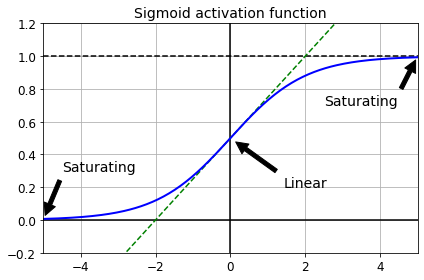

In [3]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("sigmoid_saturation_plot")
plt.show()

## Xavier and He Initialization

Note: the book uses `tensorflow.contrib.layers.fully_connected()` rather than `tf.layers.dense()` (which did not exist when this chapter was written). It is now preferable to use `tf.layers.dense()`, because anything in the contrib module may change or be deleted without notice. The `dense()` function is almost identical to the `fully_connected()` function. The main differences relevant to this chapter are:
* several parameters are renamed: `scope` becomes `name`, `activation_fn` becomes `activation` (and similarly the `_fn` suffix is removed from other parameters such as `normalizer_fn`), `weights_initializer` becomes `kernel_initializer`, etc.
* the default `activation` is now `None` rather than `tf.nn.relu`.
* it does not support `tensorflow.contrib.framework.arg_scope()` (introduced later in chapter 11).
* it does not support regularizer params (introduced later in chapter 11).

In [4]:
import tensorflow as tf
tf.__version__
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard, LearningRateScheduler
from tensorflow.keras import datasets, layers, models

import datetime

In [5]:
#reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300

In [6]:
he_init = tf.keras.initializers.he_normal(seed=42)


## Nonsaturating Activation Functions

### Leaky ReLU

In [7]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

Saving figure leaky_relu_plot


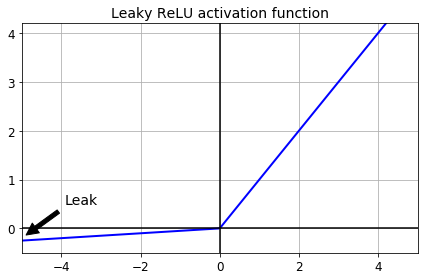

In [8]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

save_fig("leaky_relu_plot")
plt.show()

Implementing Leaky ReLU in TensorFlow:

In [9]:
alpha = 0.01
def leaky_relu(z, name=None):
    return tf.maximum(alpha * z, z, name=name)

Let's train a neural network on MNIST using the Leaky ReLU. First let's create the graph:

In [10]:
#reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10
learning_rate = 0.01

In [11]:
(X_train_2d, y_train_0), (X_test_2d, y_test_0) = tf.keras.datasets.mnist.load_data()
X_train = X_train_2d.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test_2d.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train_0.astype(np.int32)
y_test = y_test_0.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [12]:
#with Leaky ReLU and He Initialization
model = keras.Sequential([
    keras.layers.Dense(n_hidden1, kernel_initializer=he_init, activation=leaky_relu),
#    keras.layers.Dense(n_hidden1, kernel_initializer=he_init, activation=tf.nn.leaky_relu),
    keras.layers.Dense(n_hidden2, kernel_initializer=he_init, activation=leaky_relu),
#    keras.layers.Dense(n_outputs, kernel_initializer=he_init, activation=None')
    keras.layers.Dense(n_outputs, kernel_initializer=he_init, activation='softmax')
])    

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [28]:
modelelu = keras.Sequential([
    keras.layers.Dense(n_hidden1, kernel_initializer=he_init, activation='elu'),
#    keras.layers.Dense(n_hidden1, kernel_initializer=he_init, activation=tf.nn.leaky_relu),
    keras.layers.Dense(n_hidden2, kernel_initializer=he_init, activation='elu'),
#    keras.layers.Dense(n_outputs, kernel_initializer=he_init, activation=None')
    keras.layers.Dense(n_outputs, kernel_initializer=he_init, activation='softmax')
])    

modelelu.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
#with ReLU and He initialization
model2 = keras.Sequential([
    keras.layers.Dense(n_hidden1, kernel_initializer=he_init, activation='relu'),
#    keras.layers.Dense(n_hidden1, kernel_initializer=he_init, activation=tf.nn.leaky_relu),
    keras.layers.Dense(n_hidden2, kernel_initializer=he_init, activation='relu'),
#    keras.layers.Dense(n_outputs, kernel_initializer=he_init, activation=None')
    keras.layers.Dense(n_outputs, kernel_initializer=he_init, activation='softmax')
])    

model2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
#with Leaky ReLU without He initialization
model3 = keras.Sequential([
    keras.layers.Dense(n_hidden1, activation=leaky_relu),
#    keras.layers.Dense(n_hidden1, kernel_initializer=he_init, activation=tf.nn.leaky_relu),
    keras.layers.Dense(n_hidden2, activation=leaky_relu),
#    keras.layers.Dense(n_outputs, kernel_initializer=he_init, activation=None')
    keras.layers.Dense(n_outputs, activation='softmax')
])    

model3.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
#with ReLU without He initialization
model4 = keras.Sequential([
    keras.layers.Dense(n_hidden1, activation='relu'),
#    keras.layers.Dense(n_hidden1, kernel_initializer=he_init, activation=tf.nn.leaky_relu),
    keras.layers.Dense(n_hidden2, activation='relu'),
#    keras.layers.Dense(n_outputs, kernel_initializer=he_init, activation=None')
    keras.layers.Dense(n_outputs, activation='softmax')
])    

model4.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [18]:
#log_dir="logs_11/model/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir="logs_11/model/"
file_writer = tf.summary.create_file_writer(log_dir + "/metrics")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, 
                                                      update_freq=10, profile_batch = 0)

In [19]:
n_epochs = 100
n_batches = 100

model.fit(X_train, y_train, epochs=n_epochs,
          batch_size=n_batches,
          shuffle=True,
#          validation_split=0.1,
          validation_data=(X_valid, y_valid),
          validation_freq=1,
          callbacks=[tensorboard_callback]          
         )    


Train on 55000 samples, validate on 5000 samples
Epoch 1/100
55000/55000 [==============================] - 2s 30us/sample - loss: 0.9068 - accuracy: 0.7708 - val_loss: 0.4570 - val_accuracy: 0.8860
Epoch 2/100
55000/55000 [==============================] - 1s 23us/sample - loss: 0.4078 - accuracy: 0.8884 - val_loss: 0.3410 - val_accuracy: 0.9072
Epoch 3/100
55000/55000 [==============================] - 1s 23us/sample - loss: 0.3358 - accuracy: 0.9059 - val_loss: 0.2985 - val_accuracy: 0.9190
Epoch 4/100
55000/55000 [==============================] - 1s 23us/sample - loss: 0.2992 - accuracy: 0.9157 - val_loss: 0.2705 - val_accuracy: 0.9280
Epoch 5/100
55000/55000 [==============================] - 1s 24us/sample - loss: 0.2740 - accuracy: 0.9233 - val_loss: 0.2509 - val_accuracy: 0.9324
Epoch 6/100
55000/55000 [==============================] - 1s 24us/sample - loss: 0.2543 - accuracy: 0.9279 - val_loss: 0.2340 - val_accuracy: 0.9354
Epoch 7/100
55000/55000 [==========================

Epoch 55/100
55000/55000 [==============================] - 1s 24us/sample - loss: 0.0530 - accuracy: 0.9861 - val_loss: 0.0838 - val_accuracy: 0.9762
Epoch 56/100
55000/55000 [==============================] - 1s 24us/sample - loss: 0.0519 - accuracy: 0.9866 - val_loss: 0.0841 - val_accuracy: 0.9768
Epoch 57/100
55000/55000 [==============================] - 1s 24us/sample - loss: 0.0507 - accuracy: 0.9871 - val_loss: 0.0822 - val_accuracy: 0.9772
Epoch 58/100
55000/55000 [==============================] - 1s 24us/sample - loss: 0.0497 - accuracy: 0.9874 - val_loss: 0.0820 - val_accuracy: 0.9772
Epoch 59/100
55000/55000 [==============================] - 1s 23us/sample - loss: 0.0486 - accuracy: 0.9875 - val_loss: 0.0815 - val_accuracy: 0.9760
Epoch 60/100
55000/55000 [==============================] - 1s 23us/sample - loss: 0.0476 - accuracy: 0.9881 - val_loss: 0.0830 - val_accuracy: 0.9770
Epoch 61/100
55000/55000 [==============================] - 1s 23us/sample - loss: 0.0468 - ac

In [29]:
modelelu.fit(X_train, y_train, epochs=n_epochs,
          batch_size=n_batches,
          shuffle=True,
#          validation_split=0.1,
          validation_data=(X_valid, y_valid),
          validation_freq=1,
          callbacks=[tensorboard_callback]          
         )   

Train on 55000 samples, validate on 5000 samples
Epoch 1/100
55000/55000 [==============================] - 1s 25us/sample - loss: 0.7274 - accuracy: 0.8063 - val_loss: 0.4217 - val_accuracy: 0.8908
Epoch 2/100
55000/55000 [==============================] - 1s 22us/sample - loss: 0.3951 - accuracy: 0.8893 - val_loss: 0.3440 - val_accuracy: 0.9068
Epoch 3/100
55000/55000 [==============================] - 1s 22us/sample - loss: 0.3448 - accuracy: 0.9018 - val_loss: 0.3101 - val_accuracy: 0.9160
Epoch 4/100
55000/55000 [==============================] - 1s 23us/sample - loss: 0.3185 - accuracy: 0.9093 - val_loss: 0.2896 - val_accuracy: 0.9206
Epoch 5/100
55000/55000 [==============================] - 1s 23us/sample - loss: 0.3006 - accuracy: 0.9146 - val_loss: 0.2763 - val_accuracy: 0.9252
Epoch 6/100
55000/55000 [==============================] - 1s 23us/sample - loss: 0.2868 - accuracy: 0.9185 - val_loss: 0.2654 - val_accuracy: 0.9292
Epoch 7/100
55000/55000 [==========================

Epoch 55/100
55000/55000 [==============================] - 1s 22us/sample - loss: 0.0812 - accuracy: 0.9779 - val_loss: 0.0952 - val_accuracy: 0.9714
Epoch 56/100
55000/55000 [==============================] - 1s 23us/sample - loss: 0.0799 - accuracy: 0.9775 - val_loss: 0.0963 - val_accuracy: 0.9716
Epoch 57/100
55000/55000 [==============================] - 1s 22us/sample - loss: 0.0785 - accuracy: 0.9782 - val_loss: 0.0941 - val_accuracy: 0.9732
Epoch 58/100
55000/55000 [==============================] - 1s 22us/sample - loss: 0.0774 - accuracy: 0.9786 - val_loss: 0.0935 - val_accuracy: 0.9718
Epoch 59/100
55000/55000 [==============================] - 1s 23us/sample - loss: 0.0760 - accuracy: 0.9792 - val_loss: 0.0931 - val_accuracy: 0.9720
Epoch 60/100
55000/55000 [==============================] - 1s 22us/sample - loss: 0.0750 - accuracy: 0.9790 - val_loss: 0.0923 - val_accuracy: 0.9728
Epoch 61/100
55000/55000 [==============================] - 1s 23us/sample - loss: 0.0739 - ac

In [20]:
model2.fit(X_train, y_train, epochs=n_epochs,
          batch_size=n_batches,
          shuffle=True,
#          validation_split=0.1,
          validation_data=(X_valid, y_valid),
          validation_freq=1,
          callbacks=[tensorboard_callback]          
         )    
#with ReLU and He initialization

Train on 55000 samples, validate on 5000 samples
Epoch 1/100
55000/55000 [==============================] - 1s 26us/sample - loss: 0.9060 - accuracy: 0.7722 - val_loss: 0.4563 - val_accuracy: 0.8832
Epoch 2/100
55000/55000 [==============================] - 1s 22us/sample - loss: 0.4078 - accuracy: 0.8889 - val_loss: 0.3402 - val_accuracy: 0.9082
Epoch 3/100
55000/55000 [==============================] - 1s 22us/sample - loss: 0.3357 - accuracy: 0.9062 - val_loss: 0.2987 - val_accuracy: 0.9204
Epoch 4/100
55000/55000 [==============================] - 1s 23us/sample - loss: 0.2991 - accuracy: 0.9154 - val_loss: 0.2699 - val_accuracy: 0.9250
Epoch 5/100
55000/55000 [==============================] - 1s 23us/sample - loss: 0.2737 - accuracy: 0.9229 - val_loss: 0.2502 - val_accuracy: 0.9318
Epoch 6/100
55000/55000 [==============================] - 1s 23us/sample - loss: 0.2540 - accuracy: 0.9279 - val_loss: 0.2348 - val_accuracy: 0.9360
Epoch 7/100
55000/55000 [==========================

Epoch 55/100
55000/55000 [==============================] - 1s 22us/sample - loss: 0.0526 - accuracy: 0.9864 - val_loss: 0.0832 - val_accuracy: 0.9774
Epoch 56/100
55000/55000 [==============================] - 1s 23us/sample - loss: 0.0515 - accuracy: 0.9869 - val_loss: 0.0822 - val_accuracy: 0.9772
Epoch 57/100
55000/55000 [==============================] - 1s 23us/sample - loss: 0.0503 - accuracy: 0.9871 - val_loss: 0.0823 - val_accuracy: 0.9772
Epoch 58/100
55000/55000 [==============================] - 1s 22us/sample - loss: 0.0495 - accuracy: 0.9873 - val_loss: 0.0824 - val_accuracy: 0.9766
Epoch 59/100
55000/55000 [==============================] - 1s 23us/sample - loss: 0.0482 - accuracy: 0.9880 - val_loss: 0.0816 - val_accuracy: 0.9766
Epoch 60/100
55000/55000 [==============================] - 1s 22us/sample - loss: 0.0473 - accuracy: 0.9879 - val_loss: 0.0809 - val_accuracy: 0.9770
Epoch 61/100
55000/55000 [==============================] - 1s 22us/sample - loss: 0.0463 - ac

In [21]:
model3.fit(X_train, y_train, epochs=n_epochs,
          batch_size=n_batches,
          shuffle=True,
#          validation_split=0.1,
          validation_data=(X_valid, y_valid),
          validation_freq=1,
          callbacks=[tensorboard_callback]          
         )    
#with Leaky ReLU without He initialization

Train on 55000 samples, validate on 5000 samples
Epoch 1/100
55000/55000 [==============================] - 1s 27us/sample - loss: 1.0445 - accuracy: 0.7488 - val_loss: 0.5006 - val_accuracy: 0.8748
Epoch 2/100
55000/55000 [==============================] - 1s 24us/sample - loss: 0.4320 - accuracy: 0.8846 - val_loss: 0.3582 - val_accuracy: 0.9032
Epoch 3/100
55000/55000 [==============================] - 1s 24us/sample - loss: 0.3496 - accuracy: 0.9012 - val_loss: 0.3084 - val_accuracy: 0.9184
Epoch 4/100
55000/55000 [==============================] - 1s 24us/sample - loss: 0.3118 - accuracy: 0.9116 - val_loss: 0.2814 - val_accuracy: 0.9260
Epoch 5/100
55000/55000 [==============================] - 1s 24us/sample - loss: 0.2863 - accuracy: 0.9188 - val_loss: 0.2620 - val_accuracy: 0.9288
Epoch 6/100
55000/55000 [==============================] - 1s 23us/sample - loss: 0.2671 - accuracy: 0.9249 - val_loss: 0.2438 - val_accuracy: 0.9338
Epoch 7/100
55000/55000 [==========================

Epoch 55/100
55000/55000 [==============================] - 1s 23us/sample - loss: 0.0571 - accuracy: 0.9851 - val_loss: 0.0811 - val_accuracy: 0.9776
Epoch 56/100
55000/55000 [==============================] - 1s 23us/sample - loss: 0.0558 - accuracy: 0.9855 - val_loss: 0.0802 - val_accuracy: 0.9762
Epoch 57/100
55000/55000 [==============================] - 1s 23us/sample - loss: 0.0546 - accuracy: 0.9857 - val_loss: 0.0796 - val_accuracy: 0.9778
Epoch 58/100
55000/55000 [==============================] - 1s 23us/sample - loss: 0.0536 - accuracy: 0.9862 - val_loss: 0.0790 - val_accuracy: 0.9776
Epoch 59/100
55000/55000 [==============================] - 1s 24us/sample - loss: 0.0524 - accuracy: 0.9865 - val_loss: 0.0784 - val_accuracy: 0.9778
Epoch 60/100
55000/55000 [==============================] - 1s 24us/sample - loss: 0.0514 - accuracy: 0.9869 - val_loss: 0.0782 - val_accuracy: 0.9776
Epoch 61/100
55000/55000 [==============================] - 1s 24us/sample - loss: 0.0501 - ac

In [22]:
model4.fit(X_train, y_train, epochs=n_epochs,
          batch_size=n_batches,
          shuffle=True,
#          validation_split=0.1,
          validation_data=(X_valid, y_valid),
          validation_freq=1,
          callbacks=[tensorboard_callback]          
         )    
#with ReLU without He initialization

Train on 55000 samples, validate on 5000 samples
Epoch 1/100
55000/55000 [==============================] - 1s 26us/sample - loss: 1.0481 - accuracy: 0.7600 - val_loss: 0.4883 - val_accuracy: 0.8828
Epoch 2/100
55000/55000 [==============================] - 1s 22us/sample - loss: 0.4241 - accuracy: 0.8859 - val_loss: 0.3480 - val_accuracy: 0.9044
Epoch 3/100
55000/55000 [==============================] - 1s 23us/sample - loss: 0.3429 - accuracy: 0.9032 - val_loss: 0.2990 - val_accuracy: 0.9158
Epoch 4/100
55000/55000 [==============================] - 1s 23us/sample - loss: 0.3043 - accuracy: 0.9140 - val_loss: 0.2708 - val_accuracy: 0.9248
Epoch 5/100
55000/55000 [==============================] - 1s 22us/sample - loss: 0.2782 - accuracy: 0.9212 - val_loss: 0.2487 - val_accuracy: 0.9312
Epoch 6/100
55000/55000 [==============================] - 1s 22us/sample - loss: 0.2585 - accuracy: 0.9267 - val_loss: 0.2330 - val_accuracy: 0.9362
Epoch 7/100
55000/55000 [==========================

Epoch 55/100
55000/55000 [==============================] - 1s 23us/sample - loss: 0.0549 - accuracy: 0.9858 - val_loss: 0.0807 - val_accuracy: 0.9770
Epoch 56/100
55000/55000 [==============================] - 1s 22us/sample - loss: 0.0538 - accuracy: 0.9860 - val_loss: 0.0800 - val_accuracy: 0.9770
Epoch 57/100
55000/55000 [==============================] - 1s 22us/sample - loss: 0.0526 - accuracy: 0.9863 - val_loss: 0.0781 - val_accuracy: 0.9770
Epoch 58/100
55000/55000 [==============================] - 1s 22us/sample - loss: 0.0514 - accuracy: 0.9867 - val_loss: 0.0777 - val_accuracy: 0.9786
Epoch 59/100
55000/55000 [==============================] - 1s 22us/sample - loss: 0.0504 - accuracy: 0.9865 - val_loss: 0.0779 - val_accuracy: 0.9774
Epoch 60/100
55000/55000 [==============================] - 1s 22us/sample - loss: 0.0492 - accuracy: 0.9872 - val_loss: 0.0776 - val_accuracy: 0.9770
Epoch 61/100
55000/55000 [==============================] - 1s 22us/sample - loss: 0.0483 - ac

### [Practice]
**Train the above network with various alpha values and compare the results**

In [30]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)
test_loss2, test_acc2 = model2.evaluate(X_test,  y_test, verbose=2)
test_loss3, test_acc3 = model3.evaluate(X_test,  y_test, verbose=2)
test_loss4, test_acc4 = model4.evaluate(X_test,  y_test, verbose=2)
test_loss4, test_acc4 = modelelu.evaluate(X_test,  y_test, verbose=2)

print('\nTest Accuracy:', test_acc)

10000/10000 - 0s - loss: 0.0694 - accuracy: 0.9783
10000/10000 - 0s - loss: 0.0701 - accuracy: 0.9790
10000/10000 - 0s - loss: 0.0710 - accuracy: 0.9791
10000/10000 - 0s - loss: 0.0704 - accuracy: 0.9775
10000/10000 - 0s - loss: 0.0784 - accuracy: 0.9757

Test Accuracy: 0.9783


In [19]:
tf.saved_model.save(model, log_dir)

INFO:tensorflow:Assets written to: logs_11/model/assets


In [17]:
model_imported = keras.models.load_model(log_dir)


In [18]:
test_loss, test_acc = model_imported.evaluate(X_test,  y_test, verbose=2) # required for executing summary method
model_imported.summary()

10000/10000 - 1s - loss: 0.1991 - accuracy: 0.9434
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  235500    
_________________________________________________________________
dense_1 (Dense)              multiple                  30100     
_________________________________________________________________
dense_2 (Dense)              multiple                  1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


### [Practice]
**Train the above network until val_accuracy becomes larger than 0.99 or n_epoch=100, and check the test accuracy**

**1) with leaky ReLU and without He initialization,**
**2) with ReLU and He initialization,**
**3) with leaky ReLU and He initialization.**

**Compare the results with ReLU and without He initialization (obtained in chap. 10)**

### ELU

In [24]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

Saving figure elu_plot


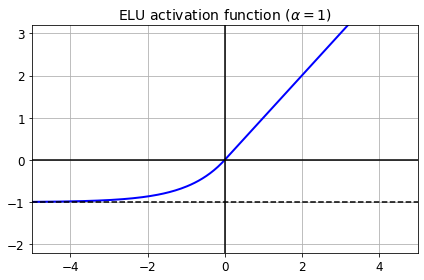

In [25]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("elu_plot")
plt.show()

Implementing ELU in TensorFlow is trivial, just specify the activation function when building each layer:

### [Practice]
**Train the above network with ELU activation and compare the results**

### SELU (Scaled ELU)

This activation function was proposed in this [great paper](https://arxiv.org/pdf/1706.02515.pdf) by Günter Klambauer, Thomas Unterthiner and Andreas Mayr, published in June 2017. During training, a neural network composed exclusively of a stack of dense layers using the SELU activation function and LeCun initialization will self-normalize: the output of each layer will tend to preserve the same mean and variance during training, which solves the vanishing/exploding gradients problem. As a result, this activation function outperforms the other activation functions very significantly for such neural nets, so you should really try it out. Unfortunately, the self-normalizing property of the SELU activation function is easily broken: you cannot use ℓ<sub>1</sub> or ℓ<sub>2</sub> regularization, regular dropout, max-norm, skip connections or other non-sequential topologies (so recurrent neural networks won't self-normalize). However, in practice it works quite well with sequential CNNs. If you break self-normalization, SELU will not necessarily outperform other activation functions.

In [31]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [32]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

Saving figure selu_plot


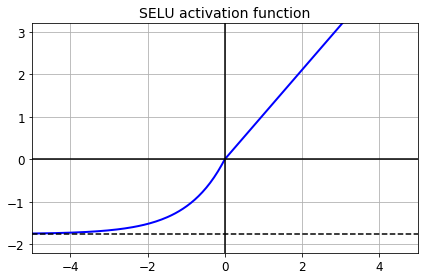

In [33]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("selu_plot")
plt.show()

By default, the SELU hyperparameters (`scale` and `alpha`) are tuned in such a way that the mean output of each neuron remains close to 0, and the standard deviation remains close to 1 (assuming the inputs are standardized with mean 0 and standard deviation 1 too). Using this activation function, even a 1,000 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem:

In [34]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # standardized inputs
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun initialization
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.83
Layer 900: mean 0.02, std deviation 1.00


The `tf.nn.selu()` function was added in TensorFlow 1.4. For earlier versions, you can use the following implementation:

In [35]:
def selu(z, scale=alpha_0_1, alpha=scale_0_1):
    return scale * tf.where(z >= 0.0, z, alpha * tf.nn.elu(z))

However, the SELU activation function cannot be used along with regular Dropout (this would cancel the SELU activation function's self-normalizing property). Fortunately, there is a Dropout variant called Alpha Dropout proposed in the same paper. It is available in `tf.contrib.nn.alpha_dropout()` since TF 1.4 (or check out [this implementation](https://github.com/bioinf-jku/SNNs/blob/master/selu.py) by the Institute of Bioinformatics, Johannes Kepler University Linz).

Let's create a neural net for MNIST using the SELU activation function:

In [36]:
#reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

learning_rate = 0.01

n_epochs = 5
batch_size = 50

model1 = keras.Sequential([
    keras.layers.Dense(n_hidden1, kernel_initializer=he_init, activation=tf.nn.selu),
    keras.layers.Dense(n_hidden2, kernel_initializer=he_init, activation=tf.nn.selu),
    keras.layers.Dense(n_outputs, kernel_initializer=he_init, activation='softmax')
])    

model1.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

log_dir="logs_11/model1/"

file_writer = tf.summary.create_file_writer(log_dir + "/metrics")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, 
                                                      update_freq=10, profile_batch = 0)

Now let's train it. Do not forget to scale the inputs to mean 0 and standard deviation 1: Already done

In [37]:
model1.fit(X_train, y_train, epochs=n_epochs,
          batch_size=n_batches,
          shuffle=True,
#          validation_split=0.1,
          validation_data=(X_valid, y_valid),
          validation_freq=1,
          callbacks=[tensorboard_callback]          
         )    

Train on 55000 samples, validate on 5000 samples
Epoch 1/5
55000/55000 [==============================] - 1s 25us/sample - loss: 0.5790 - accuracy: 0.8344 - val_loss: 0.3622 - val_accuracy: 0.9006
Epoch 2/5
55000/55000 [==============================] - 1s 22us/sample - loss: 0.3511 - accuracy: 0.8999 - val_loss: 0.3051 - val_accuracy: 0.9186
Epoch 3/5
55000/55000 [==============================] - 1s 23us/sample - loss: 0.3119 - accuracy: 0.9109 - val_loss: 0.2823 - val_accuracy: 0.9234
Epoch 4/5
55000/55000 [==============================] - 1s 23us/sample - loss: 0.2891 - accuracy: 0.9174 - val_loss: 0.2645 - val_accuracy: 0.9290
Epoch 5/5
55000/55000 [==============================] - 1s 22us/sample - loss: 0.2718 - accuracy: 0.9227 - val_loss: 0.2512 - val_accuracy: 0.9316


In [38]:
tf.saved_model.save(model1, log_dir)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: logs_11/model1/assets


In [39]:
test_loss, test_acc = model1.evaluate(X_test,  y_test, verbose=2)

print('\nTest Accuracy:', test_acc)

10000/10000 - 0s - loss: 0.2567 - accuracy: 0.9270

Test Accuracy: 0.927


##### Train Model1 for another 5 epoch. Watch the loss values.

In [40]:
n_epochs = 5
batch_size = 50

model1.fit(X_train, y_train, epochs=n_epochs,
          batch_size=n_batches,
          shuffle=True,
#          validation_split=0.1,
          validation_data=(X_valid, y_valid),
          validation_freq=1,
          callbacks=[tensorboard_callback]          
         )  

Train on 55000 samples, validate on 5000 samples
Epoch 1/5
55000/55000 [==============================] - 1s 23us/sample - loss: 0.2575 - accuracy: 0.9274 - val_loss: 0.2434 - val_accuracy: 0.9336
Epoch 2/5
55000/55000 [==============================] - 1s 22us/sample - loss: 0.2448 - accuracy: 0.9309 - val_loss: 0.2307 - val_accuracy: 0.9376
Epoch 3/5
55000/55000 [==============================] - 1s 23us/sample - loss: 0.2332 - accuracy: 0.9348 - val_loss: 0.2204 - val_accuracy: 0.9394
Epoch 4/5
55000/55000 [==============================] - 1s 23us/sample - loss: 0.2226 - accuracy: 0.9376 - val_loss: 0.2131 - val_accuracy: 0.9420
Epoch 5/5
55000/55000 [==============================] - 1s 23us/sample - loss: 0.2123 - accuracy: 0.9406 - val_loss: 0.2047 - val_accuracy: 0.9440


In [41]:
test_loss, test_acc = model1.evaluate(X_test,  y_test, verbose=2)

print('\nTest Accuracy:', test_acc)

10000/10000 - 0s - loss: 0.2086 - accuracy: 0.9401

Test Accuracy: 0.9401


# Batch Normalization

Note: the book uses `tensorflow.contrib.layers.batch_norm()` rather than `tf.layers.batch_normalization()` (which did not exist when this chapter was written). It is now preferable to use `tf.layers.batch_normalization()`, because anything in the contrib module may change or be deleted without notice. Instead of using the `batch_norm()` function as a regularizer parameter to the `fully_connected()` function, we now use `batch_normalization()` and we explicitly create a distinct layer. The parameters are a bit different, in particular:
* `decay` is renamed to `momentum`,
* `is_training` is renamed to `training`,
* `updates_collections` is removed: the update operations needed by batch normalization are added to the `UPDATE_OPS` collection and you need to explicity run these operations during training (see the execution phase below),
* we don't need to specify `scale=True`, as that is the default.

Also note that in order to run batch norm just _before_ each hidden layer's activation function, we apply the ELU activation function manually, right after the batch norm layer.

Note: since the `tf.layers.dense()` function is incompatible with `tf.contrib.layers.arg_scope()` (which is used in the book), we now use python's `functools.partial()` function instead. It makes it easy to create a `my_dense_layer()` function that just calls `tf.layers.dense()` with the desired parameters automatically set (unless they are overridden when calling `my_dense_layer()`). As you can see, the code remains very similar.

In [42]:
#reset_graph()

#import tensorflow as tf

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10
learning_rate = 0.01

n_epochs = 5
batch_size = 50

model2 = keras.Sequential([
    keras.layers.Dense(n_hidden1, kernel_initializer=he_init, activation=None),
    keras.layers.BatchNormalization(),
    keras.layers.ELU(),
    keras.layers.Dense(n_hidden2, kernel_initializer=he_init, activation=None),
    keras.layers.BatchNormalization(),
    keras.layers.ELU(),
    keras.layers.Dense(n_outputs, kernel_initializer=he_init, activation='softmax')
])    

model2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

log_dir="logs_11/model2/"

file_writer = tf.summary.create_file_writer(log_dir + "/metrics")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, 
                                                      update_freq=10, profile_batch = 0)

In [43]:
#reset_graph()

model2.fit(X_train, y_train, epochs=n_epochs,
          batch_size=n_batches,
          shuffle=True,
#          validation_split=0.1,
          validation_data=(X_valid, y_valid),
          validation_freq=1,
          callbacks=[tensorboard_callback]          
         )    

Train on 55000 samples, validate on 5000 samples
Epoch 1/5
55000/55000 [==============================] - 2s 36us/sample - loss: 0.5662 - accuracy: 0.8371 - val_loss: 0.3436 - val_accuracy: 0.9064
Epoch 2/5
55000/55000 [==============================] - 2s 30us/sample - loss: 0.3358 - accuracy: 0.9052 - val_loss: 0.2779 - val_accuracy: 0.9276
Epoch 3/5
55000/55000 [==============================] - 2s 31us/sample - loss: 0.2859 - accuracy: 0.9186 - val_loss: 0.2462 - val_accuracy: 0.9320
Epoch 4/5
55000/55000 [==============================] - 2s 30us/sample - loss: 0.2573 - accuracy: 0.9267 - val_loss: 0.2237 - val_accuracy: 0.9378
Epoch 5/5
55000/55000 [==============================] - 2s 30us/sample - loss: 0.2334 - accuracy: 0.9341 - val_loss: 0.2072 - val_accuracy: 0.9434


In [44]:
tf.saved_model.save(model2, log_dir)

INFO:tensorflow:Assets written to: logs_11/model2/assets


In [45]:
test_loss, test_acc = model2.evaluate(X_test,  y_test, verbose=2)

print('\nTest Accuracy:', test_acc)

10000/10000 - 0s - loss: 0.2078 - accuracy: 0.9404

Test Accuracy: 0.9404


To avoid repeating the same parameters over and over again, we can use Python's `partial()` function:

Let's build a neural net for MNIST, using the ELU activation function and Batch Normalization at each layer:

In [46]:
from functools import partial
BN_momentum = 0.9

my_dense_layer = partial(keras.layers.Dense,
            kernel_initializer=he_init)

model3 = keras.Sequential([
    my_dense_layer(n_hidden1, activation=None),
    keras.layers.BatchNormalization(momentum=BN_momentum),
    keras.layers.ELU(),
    my_dense_layer(n_hidden2, activation=None),
    keras.layers.BatchNormalization(momentum=BN_momentum),
    keras.layers.ELU(),
    my_dense_layer(n_outputs, activation='softmax')
])    

model3.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

log_dir="logs_11/model3/"

file_writer = tf.summary.create_file_writer(log_dir + "/metrics")
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, 
#                                                      update_freq=10, profile_batch = 0)

Saving checkpoint at each epoch. Only weights are saved

In [47]:
checkpoint_path = log_dir + "cp.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                 save_weights_only=True, verbose=1)

model3.fit(X_train, y_train, epochs=n_epochs,
          batch_size=n_batches,
          shuffle=True,
#          validation_split=0.1,
          validation_data=(X_valid, y_valid),
          validation_freq=1,
          callbacks=[cp_callback]          
         )    

Train on 55000 samples, validate on 5000 samples
Epoch 1/5
54000/55000 [============================>.] - ETA: 0s - loss: 0.3235 - accuracy: 0.9040
Epoch 00001: saving model to logs_11/model3/cp.ckpt
55000/55000 [==============================] - 2s 33us/sample - loss: 0.3214 - accuracy: 0.9044 - val_loss: 0.1853 - val_accuracy: 0.9498
Epoch 2/5
54500/55000 [============================>.] - ETA: 0s - loss: 0.1689 - accuracy: 0.9515
Epoch 00002: saving model to logs_11/model3/cp.ckpt
55000/55000 [==============================] - 1s 26us/sample - loss: 0.1689 - accuracy: 0.9515 - val_loss: 0.1378 - val_accuracy: 0.9606
Epoch 3/5
53900/55000 [============================>.] - ETA: 0s - loss: 0.1240 - accuracy: 0.9642
Epoch 00003: saving model to logs_11/model3/cp.ckpt
55000/55000 [==============================] - 1s 27us/sample - loss: 0.1237 - accuracy: 0.9644 - val_loss: 0.1138 - val_accuracy: 0.9662
Epoch 4/5
54500/55000 [============================>.] - ETA: 0s - loss: 0.0965 - ac

In [48]:
tf.saved_model.save(model3, log_dir)

INFO:tensorflow:Assets written to: logs_11/model3/assets


In [49]:
test_loss, test_acc = model3.evaluate(X_test,  y_test, verbose=2)

print('\nTest Accuracy:', test_acc)

10000/10000 - 0s - loss: 0.0863 - accuracy: 0.9735

Test Accuracy: 0.9735


Batch Norm and ELU shine mostly for much deeper nets.

## Gradient Clipping

Let's create a simple neural net for MNIST and add gradient clipping. The first part is the same as earlier (except we added a few more layers to demonstrate reusing pretrained models, see below):

Now we apply gradient clipping. For this, we need to get the gradients, use the `clipvalue` argument to clip them, then apply them:

In [50]:
#reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_outputs = 10
learning_rate = 0.01
threshold = 1.0

def create_model():
  model = keras.Sequential([
    keras.layers.Dense(n_hidden1, kernel_initializer=he_init, activation='relu'),
    keras.layers.Dense(n_hidden2, kernel_initializer=he_init, activation='relu'),
    keras.layers.Dense(n_hidden3, kernel_initializer=he_init, activation='relu'),
    keras.layers.Dense(n_outputs, kernel_initializer=he_init, activation='softmax')
])    
  model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, clipvalue=threshold),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

  return model

model4 = create_model()

# clipvalue: -threshold ~ threshold

log_dir="logs_11/model4/"

file_writer = tf.summary.create_file_writer(log_dir + "/metrics")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, 
                                                      update_freq=10, profile_batch = 0)


In [51]:
n_epochs = 5
n_batches = 50

model4.fit(X_train, y_train, epochs=n_epochs,
          batch_size=n_batches,
          shuffle=True,
#          validation_split=0.1,
          validation_data=(X_valid, y_valid),
          validation_freq=1,
          callbacks=[tensorboard_callback]          
         )  

Train on 55000 samples, validate on 5000 samples
Epoch 1/5
55000/55000 [==============================] - 3s 49us/sample - loss: 0.3027 - accuracy: 0.9080 - val_loss: 0.1304 - val_accuracy: 0.9618
Epoch 2/5
55000/55000 [==============================] - 3s 46us/sample - loss: 0.1152 - accuracy: 0.9645 - val_loss: 0.0979 - val_accuracy: 0.9716
Epoch 3/5
55000/55000 [==============================] - 3s 46us/sample - loss: 0.0767 - accuracy: 0.9763 - val_loss: 0.0823 - val_accuracy: 0.9752
Epoch 4/5
55000/55000 [==============================] - 2s 45us/sample - loss: 0.0579 - accuracy: 0.9816 - val_loss: 0.0949 - val_accuracy: 0.9720
Epoch 5/5
55000/55000 [==============================] - 2s 45us/sample - loss: 0.0435 - accuracy: 0.9866 - val_loss: 0.0793 - val_accuracy: 0.9762


The rest is the same as usual:

In [52]:
tf.saved_model.save(model4, log_dir)
model4.save(log_dir + "model4.h5")

INFO:tensorflow:Assets written to: logs_11/model4/assets


In [53]:
test_loss, test_acc = model4.evaluate(X_test,  y_test, verbose=2)

print('\nTest Accuracy:', test_acc)

10000/10000 - 0s - loss: 0.0842 - accuracy: 0.9741

Test Accuracy: 0.9741


## Reusing Pretrained Layers

## Reusing a TensorFlow Model

First you need to load the graph's structure. The `import_meta_graph()` function does just that, loading the graph's operations into the default graph, and returning a `Saver` that you can then use to restore the model's state. Note that by default, a `Saver` saves the structure of the graph into a `.meta` file, so that's the file you should load:

In [54]:
# Loaded model below is not a Kera model
# model_imported = tf.saved_model.load(log_dir)

# Loading Keras model
model_imported = keras.models.load_model(log_dir)
#model_imported = keras.models.load_model(log_dir + "/model4/model4.h5")

Next you need to get a handle on all the operations you will need for training. If you don't know the graph's structure, you can list all the operations:

In [55]:
test_loss, test_acc = model_imported.evaluate(X_test,  y_test, verbose=2)

print('\nTest Accuracy:', test_acc)

10000/10000 - 0s - loss: 0.0842 - accuracy: 0.9741

Test Accuracy: 0.9741


In [56]:
model_imported.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             multiple                  235500    
_________________________________________________________________
dense_31 (Dense)             multiple                  15050     
_________________________________________________________________
dense_32 (Dense)             multiple                  2550      
_________________________________________________________________
dense_33 (Dense)             multiple                  510       
Total params: 253,610
Trainable params: 253,610
Non-trainable params: 0
_________________________________________________________________


In [57]:
%load_ext tensorboard

In [58]:
%tensorboard --logdir ./logs_11/model4

Continue to train for another 5 epoch

In [59]:
n_epochs = 5
batch_size = 50
learning_rate = 0.005
model_imported.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model_imported.fit(X_train, y_train, epochs=n_epochs,
          batch_size=n_batches,
          shuffle=True,
#          validation_split=0.1,
          validation_data=(X_valid, y_valid),
          validation_freq=1,
          callbacks=[tensorboard_callback]          
         )  

Train on 55000 samples, validate on 5000 samples
Epoch 1/5
55000/55000 [==============================] - 3s 50us/sample - loss: 0.0223 - accuracy: 0.9936 - val_loss: 0.0599 - val_accuracy: 0.9840
Epoch 2/5
55000/55000 [==============================] - 3s 46us/sample - loss: 0.0176 - accuracy: 0.9957 - val_loss: 0.0592 - val_accuracy: 0.9838
Epoch 3/5
55000/55000 [==============================] - 3s 46us/sample - loss: 0.0159 - accuracy: 0.9964 - val_loss: 0.0587 - val_accuracy: 0.9842
Epoch 4/5
55000/55000 [==============================] - 3s 45us/sample - loss: 0.0149 - accuracy: 0.9967 - val_loss: 0.0587 - val_accuracy: 0.9836
Epoch 5/5
55000/55000 [==============================] - 3s 46us/sample - loss: 0.0141 - accuracy: 0.9971 - val_loss: 0.0584 - val_accuracy: 0.9840


In [60]:
test_loss, test_acc = model_imported.evaluate(X_test,  y_test, verbose=2)

print('\nTest Accuracy:', test_acc)

10000/10000 - 0s - loss: 0.0633 - accuracy: 0.9799

Test Accuracy: 0.9799


### [Practice]
**Train above model for n_epoch=10 from the scratch and compare the results**


## Reusing a TensorFlow Model - freezing lower layers

In [61]:
model_imported1 = keras.models.load_model(log_dir+'model4.h5')
model_imported1.summary()
weights_before=model_imported.layers[0].get_weights()
print(weights_before[0])
test_loss, test_acc = model_imported1.evaluate(X_test,  y_test, verbose=2)
#tf.print(model_imported1.layers[-4])
#tf.print(model_imported1.layers[-3])
#tf.print(model_imported1.layers[-2])
#tf.print(model_imported1.layers[-1])
#tf.print(model_imported1.layers[0])
#tf.print(model_imported1.layers[1])
#tf.print(model_imported1.layers[2])
#tf.print(model_imported1.layers[3])
#tf.print(model_imported1.layers)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             multiple                  235500    
_________________________________________________________________
dense_31 (Dense)             multiple                  15050     
_________________________________________________________________
dense_32 (Dense)             multiple                  2550      
_________________________________________________________________
dense_33 (Dense)             multiple                  510       
Total params: 253,610
Trainable params: 253,610
Non-trainable params: 0
_________________________________________________________________
[[ 0.00090821 -0.09130193  0.00594834 ...  0.07482573  0.08217672
  -0.06880955]
 [-0.00243217  0.02089237  0.02092533 ... -0.00499101  0.00867761
   0.00245165]
 [-0.0469807  -0.00284685 -0.00951752 ... -0.03931122  0.04587793
  -0.11098105]
 .

In [62]:
n_hidden4 = 50
n_hidden5 = 50
n_outputs = 10
learning_rate = 0.01
threshold = 1.0
n_epochs = 5
n_batches = 50
model_imported1.trainable = False

#x = model_imported1.layers[-2].output
#x = keras.layers.Dense(n_hidden4, kernel_initializer=he_init, activation='relu')(x)
#x = keras.layers.Dense(n_hidden5, kernel_initializer=he_init, activation='relu')(x)
#x = keras.layers.Dense(n_outputs, kernel_initializer=he_init, activation='softmax')(x)

#new_model = keras.models.Model(model_imported1.input, x, name = 'new_model')
new_model = keras.Sequential([
    model_imported1.layers[-4],
    model_imported1.layers[-3],
    model_imported1.layers[-2],
    keras.layers.Dense(n_hidden4, kernel_initializer=he_init, activation='relu'),
    keras.layers.Dense(n_hidden5, kernel_initializer=he_init, activation='relu'),
    keras.layers.Dense(n_outputs, kernel_initializer=he_init, activation='softmax')
])
new_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, clipvalue=threshold),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
new_model.fit(X_train, y_train, epochs=n_epochs,
          batch_size=n_batches,
          shuffle=True,
          validation_data=(X_valid, y_valid),
          validation_freq=1,
          callbacks=[tensorboard_callback]          
         )  


Train on 55000 samples, validate on 5000 samples
Epoch 1/5
55000/55000 [==============================] - 3s 48us/sample - loss: 0.0723 - accuracy: 0.9789 - val_loss: 0.0811 - val_accuracy: 0.9784
Epoch 2/5
55000/55000 [==============================] - 3s 46us/sample - loss: 0.0304 - accuracy: 0.9906 - val_loss: 0.0814 - val_accuracy: 0.9808
Epoch 3/5
55000/55000 [==============================] - 2s 45us/sample - loss: 0.0285 - accuracy: 0.9913 - val_loss: 0.0760 - val_accuracy: 0.9800
Epoch 4/5
55000/55000 [==============================] - 2s 45us/sample - loss: 0.0256 - accuracy: 0.9921 - val_loss: 0.0805 - val_accuracy: 0.9802
Epoch 5/5
55000/55000 [==============================] - 2s 44us/sample - loss: 0.0233 - accuracy: 0.9927 - val_loss: 0.0783 - val_accuracy: 0.9810


In [63]:
new_model.summary()
weights_after=new_model.layers[0].get_weights()
print(weights_after[0])
tf.math.equal(weights_before[0], weights_after[0])

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             multiple                  235500    
_________________________________________________________________
dense_31 (Dense)             multiple                  15050     
_________________________________________________________________
dense_32 (Dense)             multiple                  2550      
_________________________________________________________________
dense_34 (Dense)             multiple                  2550      
_________________________________________________________________
dense_35 (Dense)             multiple                  2550      
_________________________________________________________________
dense_36 (Dense)             multiple                  510       
Total params: 258,710
Trainable params: 5,610
Non-trainable params: 253,100
___________________________________________

<tf.Tensor: shape=(784, 300), dtype=bool, numpy=
array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])>

# Faster Optimizers

## Momentum optimization

In [64]:

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, y_train, epochs=n_epochs,
          batch_size=n_batches,
          shuffle=True,
          validation_data=(X_valid, y_valid),
          validation_freq=1,
          callbacks=[tensorboard_callback]          
         )  

Train on 55000 samples, validate on 5000 samples
Epoch 1/5
55000/55000 [==============================] - 3s 49us/sample - loss: 0.0653 - accuracy: 0.9786 - val_loss: 0.0989 - val_accuracy: 0.9684
Epoch 2/5
55000/55000 [==============================] - 2s 45us/sample - loss: 0.0485 - accuracy: 0.9841 - val_loss: 0.0951 - val_accuracy: 0.9728
Epoch 3/5
55000/55000 [==============================] - 2s 45us/sample - loss: 0.0358 - accuracy: 0.9885 - val_loss: 0.0801 - val_accuracy: 0.9804
Epoch 4/5
55000/55000 [==============================] - 2s 44us/sample - loss: 0.0263 - accuracy: 0.9917 - val_loss: 0.0729 - val_accuracy: 0.9824
Epoch 5/5
55000/55000 [==============================] - 2s 45us/sample - loss: 0.0191 - accuracy: 0.9945 - val_loss: 0.0823 - val_accuracy: 0.9782


## Nesterov Accelerated Gradient

In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, y_train, epochs=n_epochs,
          batch_size=n_batches,
          shuffle=True,
          validation_data=(X_valid, y_valid),
          validation_freq=1,
          callbacks=[tensorboard_callback]          
         )  

## AdaGrad

In [ ]:
#model5.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=learning_rate),
#              loss='sparse_categorical_crossentropy',
#              metrics=['accuracy'])


## RMSProp

In [ ]:
#model5.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate, momentum=0.9),
#              loss='sparse_categorical_crossentropy',
#              metrics=['accuracy'])

## Adam Optimization

In [ ]:
#model5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
#              loss='sparse_categorical_crossentropy',
#              metrics=['accuracy'])

### [Practice]
**Apply faster optimizers with various parameters and compare the results of execution times and accuracies**


## Learning Rate Scheduling

In [69]:
#reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10
he_init = tf.keras.initializers.he_normal(seed=42)

model6 = keras.Sequential([
    keras.layers.Dense(n_hidden1, kernel_initializer=he_init, activation=leaky_relu),
    keras.layers.Dense(n_hidden2, kernel_initializer=he_init, activation=leaky_relu),
    keras.layers.Dense(n_outputs, kernel_initializer=he_init, activation='softmax')
])    

initial_learning_rate=0.1
decay_steps = 10000
decay_rate = 1/10
# global_step = tf.Variable(0, trainable=False, name="global_step")
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps, decay_rate)

model6.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [70]:
log_dir="logs_11/model6/"
file_writer = tf.summary.create_file_writer(log_dir + "/metrics")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, 
                                                      update_freq=10, profile_batch = 0)

In [67]:
n_epochs = 5
n_batches = 50

model6.fit(X_train, y_train, epochs=n_epochs,
          batch_size=n_batches,
          shuffle=True,
#          validation_split=0.1,
          validation_data=(X_valid, y_valid),
          validation_freq=1,
          callbacks=[tensorboard_callback]          
         )    
#tf.print(learning_rate)

Train on 55000 samples, validate on 5000 samples
Epoch 1/5
55000/55000 [==============================] - 3s 50us/sample - loss: 0.2424 - accuracy: 0.9277 - val_loss: 0.1291 - val_accuracy: 0.9604
Epoch 2/5
55000/55000 [==============================] - 3s 46us/sample - loss: 0.1038 - accuracy: 0.9687 - val_loss: 0.1011 - val_accuracy: 0.9704
Epoch 3/5
55000/55000 [==============================] - 3s 46us/sample - loss: 0.0628 - accuracy: 0.9806 - val_loss: 0.0776 - val_accuracy: 0.9784
Epoch 4/5
55000/55000 [==============================] - 2s 45us/sample - loss: 0.0346 - accuracy: 0.9892 - val_loss: 0.0826 - val_accuracy: 0.9780
Epoch 5/5
55000/55000 [==============================] - 3s 46us/sample - loss: 0.0207 - accuracy: 0.9932 - val_loss: 0.0697 - val_accuracy: 0.9814


In [68]:
test_loss, test_acc = model6.evaluate(X_test,  y_test, verbose=2)

print('\nTest Accuracy:', test_acc)

10000/10000 - 0s - loss: 0.0659 - accuracy: 0.9811

Test Accuracy: 0.9811


# Avoiding Overfitting Through Regularization

## $\ell_1$ and $\ell_2$ regularization

Let's implement $\ell_1$ regularization manually. First, we create the model, as usual (with just one hidden layer this time, for simplicity):

In [71]:
n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10
he_init = tf.keras.initializers.he_normal(seed=42)
l1=tf.keras.regularizers.l1(l=0.01)
#l2=tf.keras.regularizers.l1(l=0.01)

model7 = keras.Sequential([
    keras.layers.Dense(n_hidden1, kernel_initializer=he_init, kernel_regularizer=l1, activation=leaky_relu),
    keras.layers.Dense(n_hidden2, kernel_initializer=he_init, kernel_regularizer=l1, activation=leaky_relu),
    keras.layers.Dense(n_outputs, kernel_initializer=he_init, kernel_regularizer=l1, activation='softmax')
])    

initial_learning_rate=0.1
decay_steps = 10000
decay_rate = 1/10
# global_step = tf.Variable(0, trainable=False, name="global_step")
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps, decay_rate)

model7.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Next, we get a handle on the layer weights, and we compute the total loss, which is equal to the sum of the usual cross entropy loss and the $\ell_1$ loss (i.e., the absolute values of the weights):

In [72]:
log_dir="logs_11/model7/"
file_writer = tf.summary.create_file_writer(log_dir + "/metrics")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, 
                                                      update_freq=10, profile_batch = 0)

In [73]:
n_epochs = 5
n_batches = 50

model7.fit(X_train, y_train, epochs=n_epochs,
          batch_size=n_batches,
          shuffle=True,
#          validation_split=0.1,
          validation_data=(X_valid, y_valid),
          validation_freq=1,
          callbacks=[tensorboard_callback]          
         )    

Train on 55000 samples, validate on 5000 samples
Epoch 1/5
55000/55000 [==============================] - 3s 53us/sample - loss: 5.7950 - accuracy: 0.6839 - val_loss: 3.8877 - val_accuracy: 0.7768
Epoch 2/5
55000/55000 [==============================] - 3s 49us/sample - loss: 3.7224 - accuracy: 0.7391 - val_loss: 3.2242 - val_accuracy: 0.8078
Epoch 3/5
55000/55000 [==============================] - 3s 48us/sample - loss: 3.1275 - accuracy: 0.7613 - val_loss: 2.7668 - val_accuracy: 0.8206
Epoch 4/5
55000/55000 [==============================] - 3s 48us/sample - loss: 2.6846 - accuracy: 0.7836 - val_loss: 2.3516 - val_accuracy: 0.8500
Epoch 5/5
55000/55000 [==============================] - 3s 48us/sample - loss: 2.3696 - accuracy: 0.7956 - val_loss: 2.1132 - val_accuracy: 0.8484


In [74]:
test_loss, test_acc = model7.evaluate(X_test,  y_test, verbose=2)

print('\nTest Accuracy:', test_acc)

10000/10000 - 0s - loss: 2.1155 - accuracy: 0.8459

Test Accuracy: 0.8459


### [Practice]
**Training the above network using various scales (l values)**


## Dropout

Note: the book uses `tf.contrib.layers.dropout()` rather than `tf.layers.dropout()` (which did not exist when this chapter was written). It is now preferable to use `tf.layers.dropout()`, because anything in the contrib module may change or be deleted without notice. The `tf.layers.dropout()` function is almost identical to the `tf.contrib.layers.dropout()` function, except for a few minor differences. Most importantly:
* you must specify the dropout rate (`rate`) rather than the keep probability (`keep_prob`), where `rate` is simply equal to `1 - keep_prob`,
* the `is_training` parameter is renamed to `training`.

In [75]:
n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10
learning_rate = 0.01
dropout_rate = 0.5  # == 1 - keep_prob

n_epochs = 5
batch_size = 50

model8 = keras.Sequential([
    keras.layers.Dropout(rate=dropout_rate),
    keras.layers.Dense(n_hidden1, kernel_initializer=he_init, activation='relu'),
    keras.layers.Dropout(rate=dropout_rate),
    keras.layers.Dense(n_hidden2, kernel_initializer=he_init, activation='relu'),
    keras.layers.Dropout(rate=dropout_rate),
    keras.layers.Dense(n_outputs, kernel_initializer=he_init, activation='softmax')
])    

model8.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

log_dir="logs_11/model8/"

file_writer = tf.summary.create_file_writer(log_dir + "/metrics")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, 
                                                      update_freq=10, profile_batch = 0)
checkpoint_path = log_dir + "cp.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                 save_weights_only=True, verbose=1)

In [76]:
n_epochs = 5
batch_size = 50

model8.fit(X_train, y_train, epochs=n_epochs,
          batch_size=n_batches,
          shuffle=True,
#          validation_split=0.1,
          validation_data=(X_valid, y_valid),
          validation_freq=1,
          callbacks=[cp_callback]          
         )  




Train on 55000 samples, validate on 5000 samples
Epoch 1/5
53750/55000 [============================>.] - ETA: 0s - loss: 1.6213 - accuracy: 0.4394
Epoch 00001: saving model to logs_11/model8/cp.ckpt
55000/55000 [==============================] - 2s 37us/sample - loss: 1.6114 - accuracy: 0.4426 - val_loss: 0.6934 - val_accuracy: 0.8310
Epoch 2/5
54800/55000 [============================>.] - ETA: 0s - loss: 0.9965 - accuracy: 0.6646
Epoch 00002: saving model to logs_11/model8/cp.ckpt
55000/55000 [==============================] - 2s 34us/sample - loss: 0.9957 - accuracy: 0.6648 - val_loss: 0.4983 - val_accuracy: 0.8758
Epoch 3/5
53650/55000 [============================>.] - ETA: 0s - loss: 0.8405 - accuracy: 0.7232
Epoch 00003: saving model to logs_11/model8/cp.ckpt
55000/55000 [==============================] - 2s 34us/sample - loss: 0.8386 - accuracy: 0.7238 - val_loss: 0.4201 - val_accuracy: 0.8956
Epoch 4/5
53950/55000 [============================>.] - ETA: 0s - loss: 0.7462 - ac

In [77]:
test_loss, test_acc = model8.evaluate(X_test,  y_test, verbose=2)

print('\nTest Accuracy:', test_acc)

10000/10000 - 1s - loss: 0.3351 - accuracy: 0.9117

Test Accuracy: 0.9117


In [78]:
tf.saved_model.save(model8, log_dir)

INFO:tensorflow:Assets written to: logs_11/model8/assets


## Max norm

Let's go back to a plain and simple neural net for MNIST with just 2 hidden layers:
MaxNorm: L2 norm of weights are less than 1.

In [79]:
n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

learning_rate = 0.01
momentum = 0.9
#MaxNorm=tf.keras.constraints.MaxNorm(max_value=1, axis=1)
MaxNorm=tf.keras.constraints.MaxNorm(max_value=1, axis=0)

model9 = keras.Sequential([
    keras.layers.Dense(n_hidden1, kernel_initializer=he_init, kernel_constraint=MaxNorm, activation='relu'),
    keras.layers.Dense(n_hidden2, kernel_initializer=he_init, kernel_constraint=MaxNorm, activation='relu'),
    keras.layers.Dense(n_outputs, kernel_initializer=he_init, kernel_constraint=MaxNorm, activation='softmax')
])    

model9.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

log_dir="logs_11/model9/"

file_writer = tf.summary.create_file_writer(log_dir + "/metrics")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, 
                                                      update_freq=10, profile_batch = 0)
checkpoint_path = log_dir + "cp.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                 save_weights_only=True, verbose=1)

In [80]:
n_epochs = 5
n_batches = 50

model9.fit(X_train, y_train, epochs=n_epochs,
          batch_size=n_batches,
          shuffle=True,
#          validation_split=0.1,
          validation_data=(X_valid, y_valid),
          validation_freq=1,
          callbacks=[cp_callback]          
         )  


Train on 55000 samples, validate on 5000 samples
Epoch 1/5
54200/55000 [============================>.] - ETA: 0s - loss: 0.4396 - accuracy: 0.8783
Epoch 00001: saving model to logs_11/model9/cp.ckpt
55000/55000 [==============================] - 2s 42us/sample - loss: 0.4368 - accuracy: 0.8790 - val_loss: 0.2308 - val_accuracy: 0.9326
Epoch 2/5
53550/55000 [============================>.] - ETA: 0s - loss: 0.2210 - accuracy: 0.9377
Epoch 00002: saving model to logs_11/model9/cp.ckpt
55000/55000 [==============================] - 2s 38us/sample - loss: 0.2207 - accuracy: 0.9377 - val_loss: 0.1846 - val_accuracy: 0.9476
Epoch 3/5
54400/55000 [============================>.] - ETA: 0s - loss: 0.1729 - accuracy: 0.9514
Epoch 00003: saving model to logs_11/model9/cp.ckpt
55000/55000 [==============================] - 2s 38us/sample - loss: 0.1730 - accuracy: 0.9514 - val_loss: 0.1481 - val_accuracy: 0.9612
Epoch 4/5
53850/55000 [============================>.] - ETA: 0s - loss: 0.1465 - ac

In [81]:
test_loss, test_acc = model9.evaluate(X_test,  y_test, verbose=2)

print('\nTest Accuracy:', test_acc)

10000/10000 - 0s - loss: 0.1372 - accuracy: 0.9605

Test Accuracy: 0.9605


## Data Augmentation

(55000, 28, 28, 1)
(55000,)
(5000, 28, 28, 1)
(5000,)
(10000, 28, 28, 1)
(10000,)


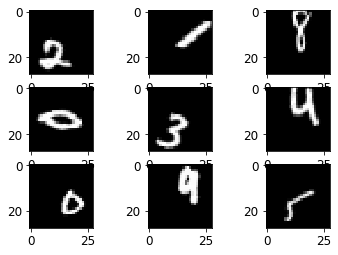

In [82]:
# Data augmentation example: shift, rotate, resize, flip, shear, blur, crop, change contrasts/brightness/saturation/hue
import random

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import datetime

# Data augmentation
datagen = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True,
        rotation_range=20,    # max rotation angle. 0: no rotation
        width_shift_range=0.3,# max horizontal shift. 0: no shift
        height_shift_range=0.3,# max vertical shift. 0: no shift
        shear_range=0.5,       # max shear range. 0: no shear
        zoom_range=(0.9, 2.0), # Scaling range: 0.9 ~ 2. a number: [1-number, 1+number]. 0: no scaling
        horizontal_flip=False, # no horizontal flip.
        vertical_flip=False,   # no vertical flip
        fill_mode='constant',
        cval=0,
)

X_train = X_train_2d.astype(np.float32).reshape((-1, 28, 28,1))
#X_train = X_train.astype('float32')
y_train = y_train_0.astype(np.int32)
#y_train = y_train_0.astype('int32')
X_test = X_test_2d.astype(np.float32).reshape((X_test_2d.shape[0], 28, 28,1))
y_test = y_test_0.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

datagen.fit(X_train)

# configure batch size and retrieve one batch of images
for x_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
    # create a grid of 3x3 images
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(x_batch[i].reshape(28, 28), cmap=plt.get_cmap('gray'))
    # show the plot
    plt.show()
    break

#
#train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
#test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

#train_dataset = train_dataset.shuffle(NUM_TRAIN_SAMPLES).batch(n_batches, drop_remainder=True)
#test_dataset = test_dataset.batch(n_batches, drop_remainder=True)



In [83]:
n_inputs = 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10
n_epochs = 5
n_batches = 50

model10 = tf.keras.Sequential([
    keras.layers.Flatten(input_shape=(n_inputs, n_inputs,1)),
    keras.layers.Dense(n_hidden1,  kernel_initializer=he_init),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.Dense(n_hidden2,  kernel_initializer=he_init),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.Dense(n_outputs,  kernel_initializer=he_init, activation='softmax'),
])

#modelcompile
model10.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

log_dir="logs_11/model10/"

file_writer = tf.summary.create_file_writer(log_dir + "/metrics")
#file_writer.set_as_default()

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch = 0)

n_epochs = 5
n_batches = 50
model10.fit(datagen.flow(X_train, y_train, batch_size=n_batches, shuffle=True), 
          epochs=n_epochs,
          validation_data=(X_valid, y_valid), 
          validation_freq=1,
          callbacks=[tensorboard_callback])

  ...
    to  
  ['...']
Train for 1100 steps, validate on 5000 samples
Epoch 1/5
1100/1100 [==============================] - 15s 14ms/step - loss: 1.5192 - accuracy: 0.4849 - val_loss: 248.9612 - val_accuracy: 0.3200
Epoch 2/5
1100/1100 [==============================] - 15s 13ms/step - loss: 0.9765 - accuracy: 0.6790 - val_loss: 366.9779 - val_accuracy: 0.2980
Epoch 3/5
1100/1100 [==============================] - 15s 13ms/step - loss: 0.8161 - accuracy: 0.7356 - val_loss: 353.5507 - val_accuracy: 0.3368
Epoch 4/5
1100/1100 [==============================] - 15s 13ms/step - loss: 0.7221 - accuracy: 0.7671 - val_loss: 346.7899 - val_accuracy: 0.3376
Epoch 5/5
1100/1100 [==============================] - 15s 13ms/step - loss: 0.6652 - accuracy: 0.7890 - val_loss: 368.3615 - val_accuracy: 0.3294


In [84]:
test_loss, test_acc = model10.evaluate(X_test,  y_test, verbose=2)

print('\nTest Accuracy:', test_acc)

10000/10000 - 1s - loss: 368.6114 - accuracy: 0.3347

Test Accuracy: 0.3347
